# Vehicle Detection and Tracking
## Project Notebook
### Jack Zhang

#### Code cell 1 - Functions from Udacity project lesson

In [18]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm='L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)       
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm='L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_color(img, conv='LUV'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB':
        return img

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        #image = np.uint8(image*255) #use this to convert to 8-bit
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    bboxes = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #hog_features = hog_feat1
            
            xleft = xpos*pix_per_cell+12
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))      
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    return bboxes

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    heatmap[heatmap[96:1280-96,496:564] <= threshold*2]=0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

#### Code cell 2 - Import modules

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import pickle

#### Code cell 3 - Explore color spaces

In [ ]:
img = mpimg.imread('./test_images/test1.jpg')

color_spaces=['RGB','HSV','LUV','HLS','YUV','YCrCb']
#print(len(color_spaces))

# Plot the result
f, axes = plt.subplots(6, 3, figsize=(20, 20))
f.tight_layout()
axes=axes.ravel()
# Visualize
for x in range(0, len(color_spaces)):
    if color_spaces[x] == 'HSV':
        color_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        axes[3].imshow(color_image[:,:,0], cmap='gray')
        axes[3].set_title('HSV: channel H', fontsize=12)
        axes[4].imshow(color_image[:,:,1], cmap='gray')
        axes[4].set_title('HSV: channel S', fontsize=12)
        axes[5].imshow(color_image[:,:,2], cmap='gray')
        axes[5].set_title('HSV: channel V', fontsize=12)
    elif color_spaces[x] == 'LUV':
        color_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        axes[6].imshow(color_image[:,:,0], cmap='gray')
        axes[6].set_title('LUV: channel L', fontsize=12)
        axes[7].imshow(color_image[:,:,1], cmap='gray')
        axes[7].set_title('LUV: channel U', fontsize=12)
        axes[8].imshow(color_image[:,:,2], cmap='gray')
        axes[8].set_title('LUV: channel V', fontsize=12)
    elif color_spaces[x] == 'HLS':
        color_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        axes[9].imshow(color_image[:,:,0], cmap='gray')
        axes[9].set_title('HLS: channel H', fontsize=12)
        axes[10].imshow(color_image[:,:,1], cmap='gray')
        axes[10].set_title('HLS: channel L', fontsize=12)
        axes[11].imshow(color_image[:,:,2], cmap='gray')
        axes[11].set_title('HLS: channel S', fontsize=12)
    elif color_spaces[x] == 'YUV':
        color_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        axes[12].imshow(color_image[:,:,0], cmap='gray')
        axes[12].set_title('YUV: channel Y', fontsize=12)
        axes[13].imshow(color_image[:,:,1], cmap='gray')
        axes[13].set_title('YUV: channel U', fontsize=12)
        axes[14].imshow(color_image[:,:,2], cmap='gray')
        axes[14].set_title('YUV: channel V', fontsize=12)
    elif color_spaces[x] == 'YCrCb':
        color_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        axes[15].imshow(color_image[:,:,0], cmap='gray')
        axes[15].set_title('YCrCb: channel Y', fontsize=12)
        axes[16].imshow(color_image[:,:,1], cmap='gray')
        axes[16].set_title('YCrCb: channel Cr', fontsize=12)
        axes[17].imshow(color_image[:,:,2], cmap='gray')
        axes[17].set_title('YCrCb: channel Cb', fontsize=12)
    else: 
        color_image = np.copy(img)
        axes[0].imshow(color_image[:,:,0], cmap='gray')
        axes[0].set_title('RGB: channel R', fontsize=12)
        axes[1].imshow(color_image[:,:,1], cmap='gray')
        axes[1].set_title('RGB: channel G', fontsize=12)
        axes[2].imshow(color_image[:,:,2], cmap='gray')
        axes[2].set_title('RGB: channel B', fontsize=12)
    
f.savefig('./output_images/color_space_channels.png')

#### Code cell 4/5 - Read in data

In [20]:
### Small dataset
# Read in cars and notcars
cars = []
notcars = []
images = glob.glob('./images_vehicle/*.jpeg')
for image in images:
    cars.append(image)

images = glob.glob('./images_nonvehicle/*.jpeg')
for image in images:
    notcars.append(image)

print(str(len(cars))+' images of cars')
print(str(len(notcars))+' images of notcars')

1196 images of cars
1125 images of notcars


In [36]:
### Large dataset
# Read in cars and notcars
cars = []
notcars = []
images = glob.glob('./vehicles/*/*.png')
for image in images:
    cars.append(image)

images = glob.glob('./non-vehicles/*/*.png')
for image in images:
    notcars.append(image)
    
print(str(len(cars))+' images of cars')
print(str(len(notcars))+' images of notcars')

8792 images of cars
8968 images of notcars


#### Code cell 6 - Train classifier

In [48]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

import matplotlib.image as mpimg

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Save model
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["X_scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins

pickle.dump( dist_pickle, open( "dist_pickle.p", "wb" ))
print('Saved model')

Using: 9 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 3840
11.53 Seconds to train SVC...
Test Accuracy of SVC =  0.9783
Saved model


#### Code cell 7 - Visualize features

Text(0.5,1,'NotCar Image Color')

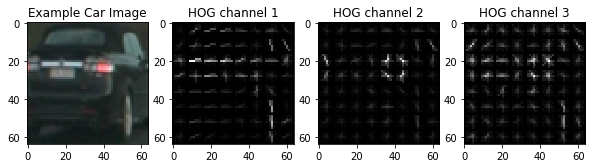

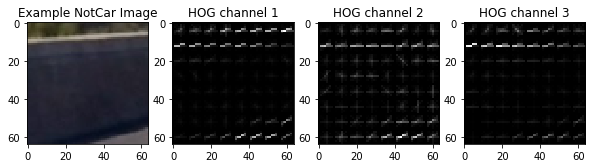

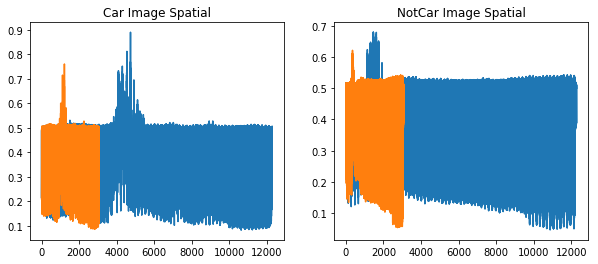

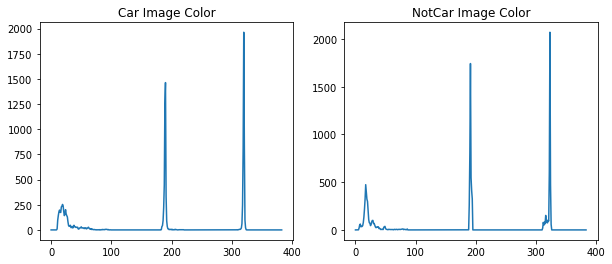

In [34]:
### Visualize features on test images
ind = np.random.randint(0, len(cars))
test_orig=mpimg.imread(cars[ind])
test_image = cv2.cvtColor(test_orig, cv2.COLOR_RGB2YCrCb)
test_not_orig=mpimg.imread(notcars[ind])
test_not = cv2.cvtColor(test_not_orig, cv2.COLOR_RGB2YCrCb)

orient=12
features, hog_image1=get_hog_features(test_image[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
features, hog_not1=get_hog_features(test_not[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
features, hog_image2=get_hog_features(test_image[:,:,1], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
features, hog_not2=get_hog_features(test_not[:,:,1], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
features, hog_image3=get_hog_features(test_image[:,:,2], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
features, hog_not3=get_hog_features(test_not[:,:,2], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
# Plot the examples
fig = plt.figure(figsize=[10,4])
plt.subplot(141)
plt.imshow(test_orig, cmap='gray')
plt.title('Example Car Image')
plt.subplot(142)
plt.imshow(hog_image1, cmap='gray')
plt.title('HOG channel 1')
plt.subplot(143)
plt.imshow(hog_image2, cmap='gray')
plt.title('HOG channel 2')
plt.subplot(144)
plt.imshow(hog_image3, cmap='gray')
plt.title('HOG channel 3')

fig = plt.figure(figsize=[10,4])
plt.subplot(141)
plt.imshow(test_not_orig, cmap='gray')
plt.title('Example NotCar Image')
plt.subplot(142)
plt.imshow(hog_not1, cmap='gray')
plt.title('HOG channel 1')
plt.subplot(143)
plt.imshow(hog_not2, cmap='gray')
plt.title('HOG channel 2')
plt.subplot(144)
plt.imshow(hog_not3, cmap='gray')
plt.title('HOG channel 3')

spat_size=32
spatial=bin_spatial(test_image, size=(spat_size, spat_size))
spatial_not=bin_spatial(test_not, size=(spat_size,spat_size))

fig = plt.figure(figsize=[10,4])
plt.subplot(121)
plt.plot(test_image.ravel())
plt.plot(spatial)
plt.title('Car Image Spatial')
plt.subplot(122)
plt.plot(test_not.ravel())
plt.plot(spatial_not)
plt.title('NotCar Image Spatial')

nbins=128
chist=color_hist(test_image, nbins, bins_range=(0, 1))
chist_not=color_hist(test_not, nbins, bins_range=(0, 1))

fig = plt.figure(figsize=[10,4])
plt.subplot(121)
plt.plot(chist)
plt.title('Car Image Color')
plt.subplot(122)
plt.plot(chist_not)
plt.title('NotCar Image Color')

#### Code cell 8/9 - Test classifier on video

In [23]:
### image process pipeline

dist_pickle = pickle.load( open("dist_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

scales = [1, 1.5, 2]
ystarts = [384,400,400]
ystops = [512,592,656]
num_frames=1

num_boxes=[]
frame_boxes=[]

def process_image(img, num_boxes=num_boxes, frame_boxes=frame_boxes):
    boxes=[]
    for x in range(0, len(scales)):
        bboxes = find_cars(img, ystart=ystarts[x], ystop=ystops[x], scale=scales[x], svc=svc, X_scaler=X_scaler, orient=orient, 
                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
                           hist_bins=hist_bins)
        #print('bboxes found:'+str(len(bboxes)))
        #print(bboxes)
        boxes.extend(bboxes) # contains all bounding boxes over all the scaling samples for 1 frame
        
    # check how many frames have been saved
    if len(num_boxes)>=num_frames:
        del frame_boxes[0:num_boxes[0]] # delete earliest frame boxes
        del num_boxes[0] # delete first entry in num_boxes

    frame_boxes.extend(boxes)
    num_boxes.append(len(boxes)) # append    
    #print(num_boxes) 
    #print(len(frame_boxes))
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,frame_boxes)
    #thres = np.maximum(np.amax(heat)*.5,5)
    thres = 3
    #print(thres)
    heat = apply_threshold(heat,thres)
    heatmap = np.clip(heat, 0, 255)
    #print(np.amax(heatmap))
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


In [9]:
### Run pipeline on video
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

num_boxes=[]
frame_boxes=[]

clip_output='clip_output.mp4'
clip_input=VideoFileClip('project_video.mp4')#.subclip(19,22)
clip=clip_input.fl_image(process_image)
%time clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video clip_output.mp4
[MoviePy] Writing video clip_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [27:11<00:01,  1.29s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: clip_output.mp4 

Wall time: 27min 12s


#### Code cell 10-13 - Additional visualization

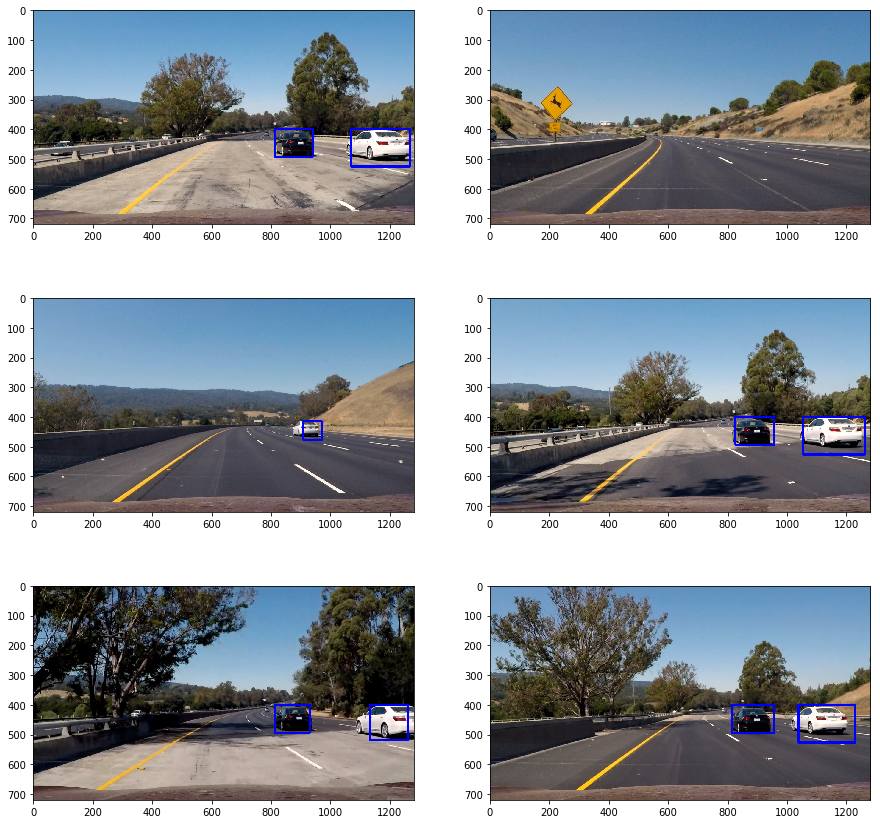

In [24]:
### Visualize pipeline on test images
fig = plt.figure(figsize=[15,15])
plt.subplot(321)
num_boxes=[]
frame_boxes=[]
image = mpimg.imread('./test_images/test1.jpg')
result = process_image(image)
plt.imshow(result)
plt.subplot(322)
num_boxes=[]
frame_boxes=[]
image = mpimg.imread('./test_images/test2.jpg')
result = process_image(image)
plt.imshow(result)
plt.subplot(323)
num_boxes=[]
frame_boxes=[]
image = mpimg.imread('./test_images/test3.jpg')
result = process_image(image)
plt.imshow(result)
plt.subplot(324)
num_boxes=[]
frame_boxes=[]
image = mpimg.imread('./test_images/test4.jpg')
result = process_image(image)
plt.imshow(result)
plt.subplot(325)
num_boxes=[]
frame_boxes=[]
image = mpimg.imread('./test_images/test5.jpg')
result = process_image(image)
plt.imshow(result)
plt.subplot(326)
num_boxes=[]
frame_boxes=[]
image = mpimg.imread('./test_images/test6.jpg')
result = process_image(image)
plt.imshow(result)

9.0


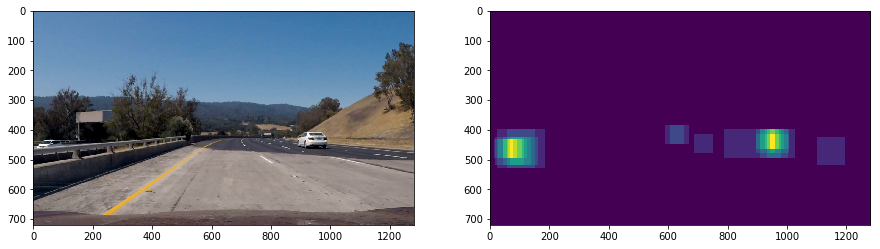

In [21]:
### Test on video frame
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clip_input=VideoFileClip('project_video.mp4').subclip(24,25)
test=clip_input.get_frame(0)

fig = plt.figure(figsize=[15,10])
plt.subplot(121)
plt.imshow(test)
plt.subplot(122)
plt.imshow(process_image(test))

In [7]:
def find_cars2(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    bboxes = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = img_tosearch[:,:,0]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            xleft = xpos*pix_per_cell+12
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))          
 
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
            bboxes.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    return draw_img

def process_image2(img, num_boxes=num_boxes, frame_boxes=frame_boxes):
    boxes=[]
    for x in range(0, len(scales)):
        output = find_cars2(img, ystart=ystarts[x], ystop=ystops[x], scale=scales[x], svc=svc, X_scaler=X_scaler, orient=orient, 
                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
                           hist_bins=hist_bins)
    return output

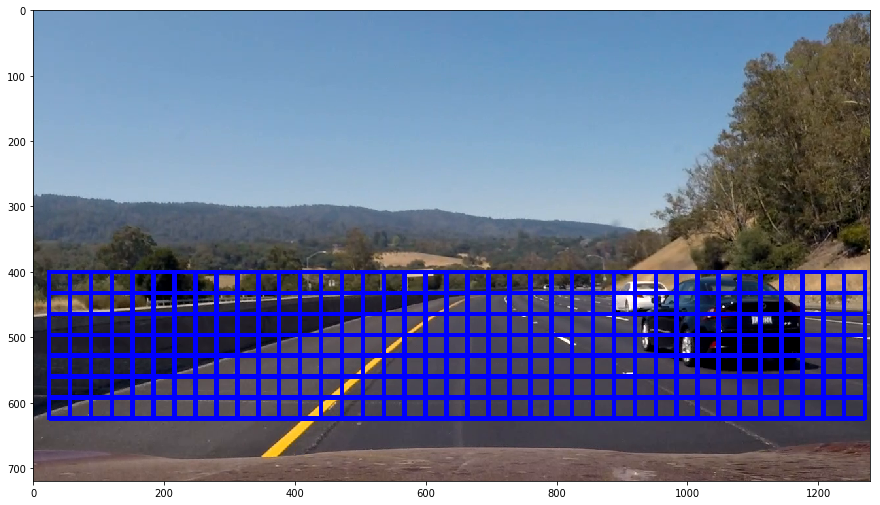

In [9]:
### Visualize window search
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

scales = [1, 1.5, 2]
ystarts = [384,400,400]
ystops = [512,592,656]
scales=[2]
ystarts=[400]
ystops=[656]
num_frames=1

num_boxes=[]
frame_boxes=[]

clip_input=VideoFileClip('project_video.mp4').subclip(21,22)
test=clip_input.get_frame(10)

fig = plt.figure(figsize=[15,10])
plt.imshow(process_image2(test))